# Predicting ICU mortality given various factors 
Outcome = death in ICU

### Demographic 
* age, gender, ethnicity, marital status

### Admission, ICU 
* admission type, first_careunit, time to icu

### Comorbidity burden 
* admission Charlson Comorbidity Index

### First day lab values 
* e.g. mean value creatinine/lactate/sodium....

In [53]:
import matplotlib.pyplot as plt

In [29]:
import pandas as pd 

df = pd.read_parquet('data/curated/icu_admissions_patients_charlson_diagnoses_labs')

## basic checks
print(df.shape)
df.head()

(61532, 107)


,row_id,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,...,count_val_GLUCOSE,count_val_HEMATOCRIT,count_val_HEMOGLOBIN,count_val_LACTATE,count_val_MAGNESIUM,count_val_PHOSPHATE,count_val_PLATELET,count_val_POTASSIUM,count_val_SODIUM,count_val_WBC
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,...,5.0,2.0,2.0,2.0,3.0,3.0,2.0,3.0,3.0,2.0
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,...,4.0,4.0,4.0,9.0,4.0,3.0,4.0,4.0,4.0,5.0
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,...,2.0,2.0,2.0,NaN,1.0,1.0,2.0,2.0,2.0,2.0
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,...,4.0,5.0,4.0,3.0,3.0,3.0,3.0,4.0,4.0,3.0
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,...,2.0,2.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0


# Cleaning

## Choose feature subset

In [30]:
## Data prep 
chosen_features = [
    # demographics
    "age_during_admission", "gender", "ethnicity_categorised",
    
    # admission / ICU metadata
    "admission_type", "first_careunit", "time_to_icu",
    
    # comorbidity burden
    "admission_CCI",
    
    # lab means
    "mean_val_CREATININE", "mean_val_LACTATE", "mean_val_SODIUM",
    "mean_val_POTASSIUM", "mean_val_WBC", "mean_val_HEMOGLOBIN",
    "mean_val_HEMATOCRIT", "mean_val_BUN", "mean_val_PLATELET",
    "mean_val_GLUCOSE", "mean_val_BICARBONATE", "mean_val_CHLORIDE"
]

## Get X and Y
X = df[chosen_features]
y = df['icu_mortality']

In [31]:
## check dtypes
X.dtypes

age_during_admission             float64
gender                            object
ethnicity_categorised             object
admission_type                    object
first_careunit                    object
time_to_icu              timedelta64[us]
admission_CCI                    float64
mean_val_CREATININE              float64
mean_val_LACTATE                 float64
mean_val_SODIUM                  float64
mean_val_POTASSIUM               float64
mean_val_WBC                     float64
mean_val_HEMOGLOBIN              float64
mean_val_HEMATOCRIT              float64
mean_val_BUN                     float64
mean_val_PLATELET                float64
mean_val_GLUCOSE                 float64
mean_val_BICARBONATE             float64
mean_val_CHLORIDE                float64
dtype: object

In [32]:
X.loc[:, 'time_to_icu_hour'] = X['time_to_icu'].dt.seconds/(60*60)
X = X.drop(columns=['time_to_icu'])

C:\Users\tanip\AppData\Local\Temp\ipykernel_27308\2728686189.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'time_to_icu_hour'] = X['time_to_icu'].dt.seconds/(60*60)


## Missing vals

In [33]:
## Check missing values 

X.isna().sum()

age_during_admission        84
gender                      84
ethnicity_categorised     8143
admission_type              84
first_careunit               0
admission_CCI                0
mean_val_CREATININE       8632
mean_val_LACTATE         30278
mean_val_SODIUM           6728
mean_val_POTASSIUM        6661
mean_val_WBC              2362
mean_val_HEMOGLOBIN       2227
mean_val_HEMATOCRIT       1992
mean_val_BUN              8642
mean_val_PLATELET         2293
mean_val_GLUCOSE          8603
mean_val_BICARBONATE      7121
mean_val_CHLORIDE         6863
time_to_icu_hour          3830
dtype: int64

In [37]:
## NUMERIC COLS
## Simple solution to imputation: use mean/median
X = X.fillna(X.median(numeric_only=True))

In [45]:
## CATEGORICAL COLS
## Impute with 'unknown'
X = X.fillna('Unknown')

In [46]:
X.isna().sum()

age_during_admission     0
gender                   0
ethnicity_categorised    0
admission_type           0
first_careunit           0
admission_CCI            0
mean_val_CREATININE      0
mean_val_LACTATE         0
mean_val_SODIUM          0
mean_val_POTASSIUM       0
mean_val_WBC             0
mean_val_HEMOGLOBIN      0
mean_val_HEMATOCRIT      0
mean_val_BUN             0
mean_val_PLATELET        0
mean_val_GLUCOSE         0
mean_val_BICARBONATE     0
mean_val_CHLORIDE        0
time_to_icu_hour         0
dtype: int64

# Checking outcome

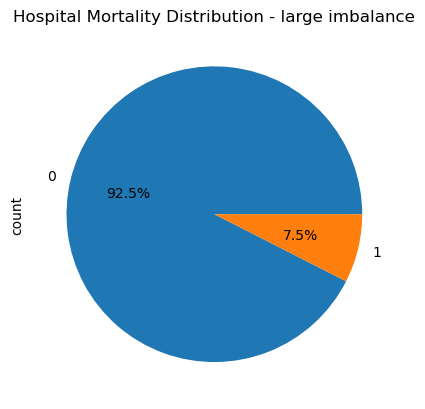

In [60]:
## Check outcome 
# percentage = y.value_counts()/len(y)
y.value_counts().plot(kind = 'pie', autopct = '%1.1f%%') ## add percentage
plt.title('Hospital Mortality Distribution - large imbalance')
plt.show()

Very high imbalance -- less than 10% mortality

## Train test split

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [64]:
## check
print(y_test.value_counts()/len(y_test))
print(y_train.value_counts()/len(y_train))

icu_mortality
0    0.925002
1    0.074998
Name: count, dtype: float64
icu_mortality
0    0.925018
1    0.074982
Name: count, dtype: float64


## OHE (cat) + Feature scaling (Num)

In [66]:
cat_cols = X.select_dtypes(object).columns
num_cols = [col for col in X.columns if col not in cat_cols]

In [67]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

## Create the pipeline
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)


# Baseline model: logistic regression

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

log_reg_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000, 
                                 class_weight="balanced")) ## recall class imabalance -- only 7.5% positives 
])

## fit the model
log_reg_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age_during_admission',
                                                   'admission_CCI',
                                                   'mean_val_CREATININE',
                                                   'mean_val_LACTATE',
                                                   'mean_val_SODIUM',
                                                   'mean_val_POTASSIUM',
                                                   'mean_val_WBC',
                                                   'mean_val_HEMOGLOBIN',
                                                   'mean_val_HEMATOCRIT',
                                                   'mean_val_BUN',
                                                   'mean_val_PLATELET',
                                                   'mean_val_GLUCOSE',
                                                   'mean_val_BICARBONATE',
                                                   'mean_val_CHLORIDE',
                                                   'time_to_icu_hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['gender', 'ethnicity_categorised', 'admission_type', 'first_careunit'], dtype='object'))])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

AUC: 0.82
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     11384
           1       0.19      0.75      0.30       923

    accuracy                           0.74     12307
   macro avg       0.58      0.75      0.57     12307
weighted avg       0.91      0.74      0.80     12307



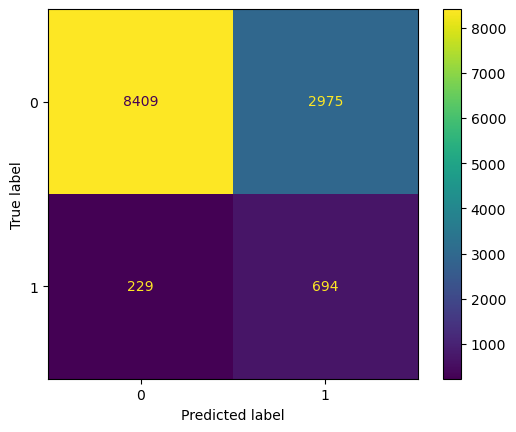

In [95]:
## Evaluate 
y_pred = log_reg_clf.predict(X_test)
y_prob = log_reg_clf.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

print(f"AUC: {roc_auc_score(y_test, y_prob):.2f}")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()


### Metrics: 

AUC = 82%, good score (AUC records how well model separates potential deaths and non deaths)

Precision for non-deaths = 97%, high value (for predicted non deaths, 97% of them are correct)

Precision for deaths = 19%, very low (for predicted deaths, only 19% of them died --> many false positives)

Recall = 75% for both (for actual positives, how many were detected)
* for all actual deaths, 75% were spotted by the model 


In [91]:
from sklearn.metrics import brier_score_loss
brier = brier_score_loss(y_test, y_prob)
print(f'Brier Score {brier:.2f}')

0.17


### Brier scores
* 0 = perfect
* 1 = worst
* 0.2 - 0.3 = moderate performance

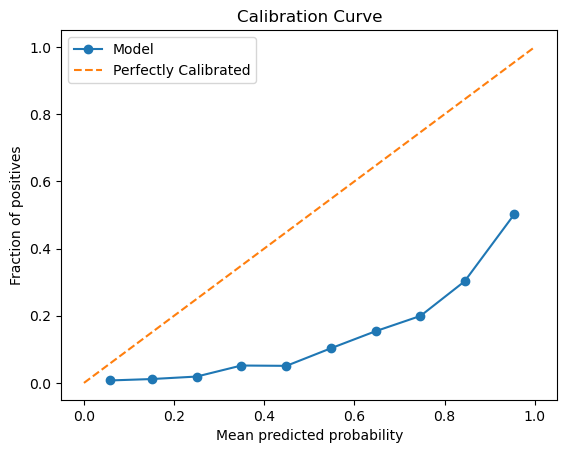

In [93]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0,1],[0,1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()


## Calibration curve

1. Points on the Diagonal
Model is well-calibrated.

Predicted probabilities match observed outcomes.

E.g., 0.3 predicted risk → 30% actual mortality.

2. Points Below the Diagonal
Model is overconfident.

Predicts higher risk than reality.

E.g., predicts 0.7 risk, but only 40% die.

3. Points Above the Diagonal
Model is underconfident.

Predicts lower risk than reality.

E.g., predicts 0.2 risk, but 50% die.

# Random Forest

In [71]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight="balanced_subsample",
    random_state=42
)

rf_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf)
])

rf_clf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age_during_admission',
                                                   'admission_CCI',
                                                   'mean_val_CREATININE',
                                                   'mean_val_LACTATE',
                                                   'mean_val_SODIUM',
                                                   'mean_val_POTASSIUM',
                                                   'mean_val_WBC',
                                                   'mean_val_HEMOGLOBIN',
                                                   'mean_val_HEMATOCRIT',
                                                   'mean_val_BUN',
                                                   'mean_val_PLATELET',
                                                   'mean_val_GLUCOSE',
                                                   'mean_val_BICARBONATE',
                                                   'mean_val_CHLORIDE',
                                                   'time_to_icu_hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['gender', 'ethnicity_categorised', 'admission_type', 'first_careunit'], dtype='object'))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=10, n_estimators=300,
                                        random_state=42))])

AUC: 0.84
              precision    recall  f1-score   support

           0       0.97      0.82      0.89     11384
           1       0.23      0.66      0.34       923

    accuracy                           0.81     12307
   macro avg       0.60      0.74      0.61     12307
weighted avg       0.91      0.81      0.85     12307



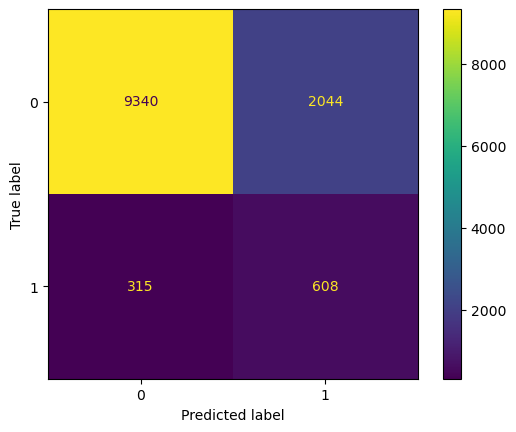

In [98]:
y_pred = rf_clf.predict(X_test)
y_prob = rf_clf.predict_proba(X_test)[:, 1]

print(f"AUC: {roc_auc_score(y_test, y_prob):.2f}")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()



Higher accuracy and AUC than logistic regression

# XGBoost

In [74]:
## manually define class weights
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos

from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc"
)
xgb_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb)
])



In [75]:
xgb_clf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age_during_admission',
                                                   'admission_CCI',
                                                   'mean_val_CREATININE',
                                                   'mean_val_LACTATE',
                                                   'mean_val_SODIUM',
                                                   'mean_val_POTASSIUM',
                                                   'mean_val_WBC',
                                                   'mean_val_HEMOGLOBIN',
                                                   'mean_val_HEMATOCRIT',
                                                   'mean_val_BUN',
                                                   'mean_val_PLATELET',
                                                   'mean_val_GLUCOSE',
                                                   'mean_val_BICARBONATE',
                                                   'mean_va...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, ...))])

AUC: 0.85
              precision    recall  f1-score   support

           0       0.97      0.83      0.90     11384
           1       0.24      0.67      0.36       923

    accuracy                           0.82     12307
   macro avg       0.61      0.75      0.63     12307
weighted avg       0.91      0.82      0.85     12307



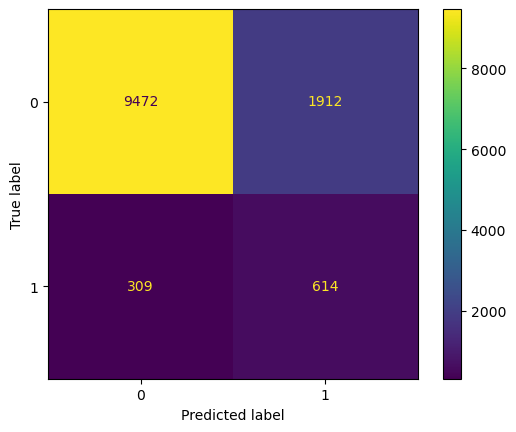

In [100]:
y_pred = xgb_clf.predict(X_test)
y_prob = xgb_clf.predict_proba(X_test)[:, 1]

print(f"AUC: {roc_auc_score(y_test, y_prob):.2f}")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()



# Feature importance

In [83]:
log_reg_clf.named_steps['preprocess'].named_transformers_['cat'].get_feature_names_out(cat_cols)

array(['gender_F', 'gender_M', 'gender_Unknown',
       'ethnicity_categorised_AMERICAN INDIAN',
       'ethnicity_categorised_ASIAN', 'ethnicity_categorised_BLACK',
       'ethnicity_categorised_HISPANIC', 'ethnicity_categorised_Unknown',
       'ethnicity_categorised_WHITE', 'admission_type_ELECTIVE',
       'admission_type_EMERGENCY', 'admission_type_NEWBORN',
       'admission_type_URGENT', 'admission_type_Unknown',
       'first_careunit_CCU', 'first_careunit_CSRU', 'first_careunit_MICU',
       'first_careunit_NICU', 'first_careunit_SICU',
       'first_careunit_TSICU'], dtype=object)

## XGB Feature Importance

In [77]:
ohe = log_reg_clf.named_steps['preprocess'].named_transformers_['cat']
cat_names = ohe.get_feature_names_out(cat_cols) ## get the col names post OHE encoded (e.g. from ethnicity --> ethnicity_black, ethnicity_white...)

## combine all processed feature names 
feature_names = num_cols + list(cat_names)
importances = xgb.feature_importances_
pd.Series(importances, index=feature_names).sort_values(ascending=False)

admission_type_EMERGENCY                 0.182448
first_careunit_CSRU                      0.075933
mean_val_LACTATE                         0.070033
admission_type_ELECTIVE                  0.060243
mean_val_BUN                             0.040904
ethnicity_categorised_Unknown            0.034003
age_during_admission                     0.030244
mean_val_BICARBONATE                     0.029512
admission_CCI                            0.028676
first_careunit_SICU                      0.025141
first_careunit_NICU                      0.023814
mean_val_WBC                             0.022790
mean_val_GLUCOSE                         0.022553
ethnicity_categorised_BLACK              0.022367
mean_val_SODIUM                          0.021344
first_careunit_MICU                      0.021274
mean_val_PLATELET                        0.020843
admission_type_NEWBORN                   0.019595
admission_type_URGENT                    0.018154
time_to_icu_hour                         0.018083
